# Toast data analysis and curation

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/perfect-toast-machine/blob/master/ptm-dataset-curation.ipynb)

Downloads data from GitHub repository into */content/dataset*, analyzes it, standardizes it, creates an Edge Impulse ready set of CSV files, and trains a NN to test viability.

## Step 1: Load the data

In [ ]:
import csv
import os
import shutil
import random
import uuid

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
### Settings
HOME_PATH = "/content"              # Location of the working directory
DATASET_PATH = "/content/dataset"   # Upload your .csv samples to this directory
OUT_PATH = "/content/out"           # Where output files go (will be deleted and recreated)
TRAIN_DIR = "training"              # Where to store training output files
TEST_DIR = "testing"                # Where to store testing output files
OUT_ZIP = "/content/out.zip"        # Where to store the zipped output files
X_WINDOW_LEN = 20                   # Number of samples in the window
X_WINDOW_STRIDE = 2                 # Number of samples to skip for the next window
Y_SCALE = 1000                      # Divide y values by this amount (convert ms to sec)

# Set aside 20% for test
TEST_RATIO = 0.2

# Hardcoded column index
TIMESTAMP_IDX = 0                   # Column number of the timestamp data
PRESSURE_IDX = 3                    # Column number of the pressure data
STATE_IDX = 11                      # Column number of the state data
BURNT_STATE_NUM = 3                 # The state that we care about

# Seed for pseudorandomness 
SEED = 42

In [ ]:
### Download data

url = "https://github.com/ShawnHymel/perfect-toast-machine/raw/main/datasets/burnt-toast-dataset.zip"
filename = "burnt-toast-dataset.zip"
filepath = os.path.join(HOME_PATH, filename)

# Start with fresh dataset directory
if os.path.exists(DATASET_PATH):
  shutil.rmtree(DATASET_PATH)
os.makedirs(DATASET_PATH)

# Download zip file
!wget {url}

# Unzip
!unzip -q {filepath} -d {DATASET_PATH}

--2022-08-20 19:31:21--  https://github.com/ShawnHymel/perfect-toast-machine/raw/main/datasets/burnt-toast-dataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ShawnHymel/perfect-toast-machine/main/datasets/burnt-toast-dataset.zip [following]
--2022-08-20 19:31:21--  https://raw.githubusercontent.com/ShawnHymel/perfect-toast-machine/main/datasets/burnt-toast-dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 266888 (261K) [application/zip]
Saving to: ‘burnt-toast-dataset.zip’

burnt-toast-dataset 100%[===================>] 260.63K  --.-KB/s    in 0.03s   

2022-08-20 19:31:22 (8.

In [ ]:
### Flatten the dataset directory
for dir in os.listdir(DATASET_PATH):
  dirpath = os.path.join(DATASET_PATH, dir)
  if os.path.isdir(dirpath):
    for filename in os.listdir(dirpath):
      shutil.move(os.path.join(dirpath, filename), os.path.join(DATASET_PATH, filename))
    shutil.rmtree(dirpath)

In [ ]:
### Read in .csv files

# Store header, raw data, and number of lines found in each .csv file
header = None
raw_data = []
filenames = []

# Read each CSV file
for filename in os.listdir(DATASET_PATH):

  sample_data = []

  # Check if the path is a file
  filepath = os.path.join(DATASET_PATH, filename)
  if not os.path.isfile(filepath):
    continue

  # Read the .csv file
  with open(filepath) as f:
    csv_reader = csv.reader(f, delimiter=',')

    # Read each line
    valid_line_counter = 0
    for line_count, line in enumerate(csv_reader):

      # Check header
      if line_count == 0:

        # Record first header as our official header for all the data
        if header == None:
          header = line

        # Check to make sure subsequent headers match the original header
        if header == line:
          filenames.append(filename)
        else:
          print("Error: Headers do not match. Skipping", filename)
          break

      # Construct raw data array, make sure number of elements match number of header labels
      else:
        if len(line) == len(header):
          sample_data.append(line)
        else:
          print("Error: Data length does not match header length. Skipping line.")
          continue

  # Append Numpy array to data list
  raw_data.append(np.array(sample_data).astype('float'))

# Print out our results
print("Number of samples:", len(raw_data))
print("Shape of sample 0:", raw_data[0].shape)
print("Number of filenames:", len(filenames))

Number of samples: 1
Shape of sample 0: (407, 11)
Number of filenames: 1


In [ ]:
### Determine sampling rate

timestamp_idx = 0
sample_rate = raw_data[0][1,timestamp_idx] - raw_data[0][0, timestamp_idx]
print("Sample rate (ms):", sample_rate)

Sample rate (ms): 500.0


## Step 2: Analyze the data

In [ ]:
### Create one long Numpy array with all the sample data
raw_data_np = []
for sample in raw_data:
  for i in range(sample.shape[0]):
    raw_data_np.append(sample[i,:])
raw_data_np = np.array(raw_data_np).astype(float)
print(raw_data_np.shape)

(407, 11)


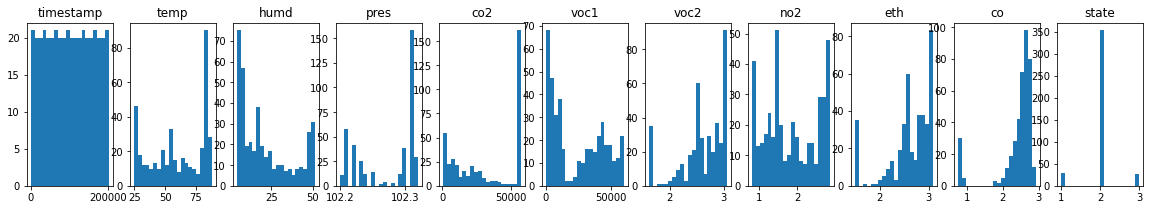

In [ ]:
### Examine the histograms of all the data

# Create subplots
num_hists = len(header)
fig, axs = plt.subplots(1, num_hists, figsize=(20,3))

# Create histogram for each category of data
for i in range(num_hists):
  _ = axs[i].hist(raw_data_np[:,i], bins=20, histtype='bar')
  axs[i].title.set_text(header[i])

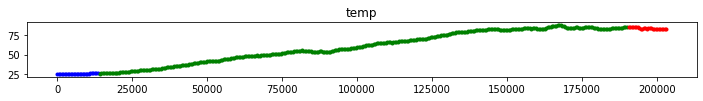

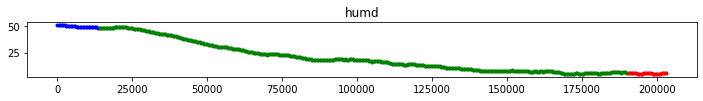

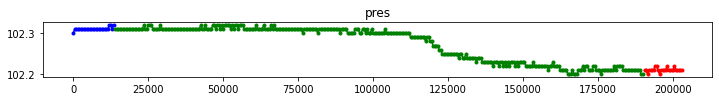

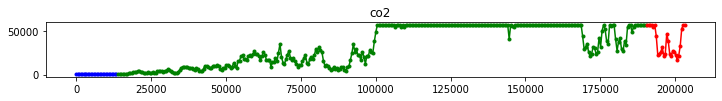

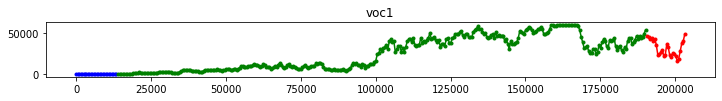

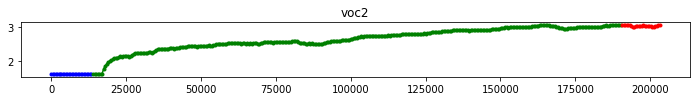

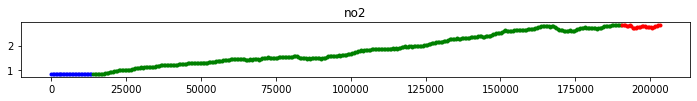

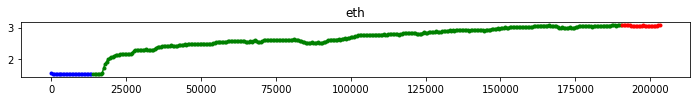

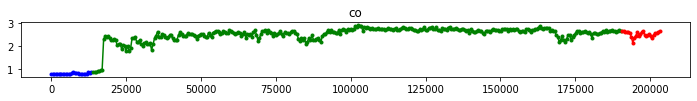

In [ ]:
### Choose 1 sample and plot the gas data over time

sample_idx = 0
num_sensors = len(header) - 2

# Calculate number of readings in each state
num_background = np.sum(raw_data[sample_idx][:,-1] == 1)
num_toasting = np.sum(raw_data[sample_idx][:,-1] == 2)
num_burnt = np.sum(raw_data[sample_idx][:,-1] == 3)

# Get x-axis (time data) for each state
t_background = raw_data[sample_idx][:num_background, 0]
t_toasting = raw_data[sample_idx][num_background:(num_background + num_toasting), 0]
t_burnt = raw_data[sample_idx][(num_background + num_toasting):, 0]
t_series = [t_background, t_toasting, t_burnt]

# Plot data from each sensor
for sensor_idx in range(1, num_sensors + 1):

  # Get the label
  label = header[sensor_idx]

  # Get the y-axis (sensor reading)
  y_background = raw_data[sample_idx][:num_background, sensor_idx]
  y_toasting = raw_data[sample_idx][num_background:(num_background + num_toasting), sensor_idx]
  y_burnt = raw_data[sample_idx][(num_background + num_toasting):, sensor_idx]
  y_series = [y_background, y_toasting, y_burnt]

  # Plot each sensor
  plt.figure(figsize=(12,1))
  plt.plot(t_background, y_background, color='blue', marker='.')
  plt.plot(t_toasting, y_toasting, color='green', marker='.')
  plt.plot(t_burnt, y_burnt, color='red', marker='.')
  plt.title(label)

## Step 3: Prepare and split the data

In [ ]:
### Construct X (gas data) and y (time until burn) regression data

X = []
y = []

# Loop through all the raw samples
for idx in range(len(raw_data)):

  # Find the time at which the burning was detected
  burnt_idxs = np.where(raw_data[idx][:, STATE_IDX] == BURNT_STATE_NUM)[0]
  burn_timestamp = raw_data[idx][min(burnt_idxs), 0]

  # Create sliding window gas data (without timestamp and state) to X and "time until burn" to y
  win_idx = 0
  while win_idx < len(raw_data[idx]):

    # Check to make sure we're not exceeding the sequence
    if win_idx + X_WINDOW_LEN > len(raw_data[idx]):
      break

    # Copy window to our X dataset
    window = raw_data[idx][win_idx:(win_idx + X_WINDOW_LEN), :]
    X.append(window)
    
    # Copy time until burned (at the end of the window) as our ground truth values
    y.append(burn_timestamp - raw_data[idx][(win_idx + X_WINDOW_LEN - 1), 0])

    # Mover window up by our stride
    win_idx += X_WINDOW_STRIDE

# Turn X and y into numpy arrays (and scale Y)
X = np.array(X)
y = np.array(y) / Y_SCALE

# Check shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (5950, 20, 12)
y shape: (5950,)


In [ ]:
### Curate the columns

# Drop column(s). Remove timestamp, pressure (it's useless), and state columns.
cols_to_delete = [TIMESTAMP_IDX, PRESSURE_IDX, STATE_IDX] 

# Remove column(s) from dataset
X_curated = np.delete(X, cols_to_delete, axis=2)

# Drop timestamp, state, and pressure from header
channel_names = [name for n, name in enumerate(header) if n not in cols_to_delete]

print(channel_names)
print(X_curated.shape)

['temp', 'humd', 'co2', 'voc1', 'voc2', 'no2', 'eth', 'co', 'nh3']
(5950, 20, 9)


In [ ]:
### Shuffle and split dataset

# Get number of samples
num_samples = X_curated.shape[0]

# Use a seed in case we want to recreate the exact results
random.seed(SEED)

# Shuffle our dataset
X_y = list(zip(list(X_curated), list(y)))
random.shuffle(X_y)
X_all, y_all = zip(*X_y)

# Calculate number of validation and test samples to put aside (round down)
num_samples_test = int(TEST_RATIO * num_samples)

# The first `num_samples_test` samples of the shuffled list becomes the test set
X_test = X_all[:num_samples_test]
y_test = y_all[:num_samples_test]

# The remaining samples become the training set
X_train = X_all[num_samples_test:]
y_train = y_all[num_samples_test:]

# Convert data to Numpy arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Print shapes of our sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4760, 20, 9)
y_train shape: (4760,)
X_test shape: (1190, 20, 9)
y_test shape: (1190,)


In [ ]:
### Function to calculate dataset metrics (mean, std dev, etc.) for each channel
def calc_metrics(X, ignore_first_col=False):

  # Calculate means, standard deviations, and ranges
  means = np.mean(X, axis=0)
  std_devs = np.std(X, axis=0)
  mins = np.min(X, axis=0)
  ranges = np.ptp(X, axis=0)

  # Drop the first column if requested
  if ignore_first_col:
    return (means[1:], std_devs[1:], mins[1:], ranges[1:])
  else:
    return (means, std_devs, mins, ranges)

In [ ]:
### Compute the metrics of the training data

# Compute per-channel metrics
X_train_flattened = np.reshape(X_train, 
                               (X_train.shape[0] * X_train.shape[1], X_train.shape[2]))
(means, std_devs, mins, ranges) = calc_metrics(X_train_flattened, ignore_first_col=False)

# Print out the results
print(channel_names)
print("Means:", [float("{:.4f}".format(x)) for x in means])
print("Std devs:", [float("{:.4f}".format(x)) for x in std_devs])
print("Mins:", [float("{:.4f}".format(x)) for x in mins])
print("Ranges:", [float("{:.4f}".format(x)) for x in ranges])

['temp', 'humd', 'co2', 'voc1', 'voc2', 'no2', 'eth', 'co', 'nh3']
Means: [75.502, 8.4883, 14913.9847, 32933.7305, 2.5958, 2.2113, 2.6475, 2.1576, 2.277]
Std devs: [23.2281, 9.0292, 18230.8385, 24429.9224, 0.3656, 0.5479, 0.3673, 0.4927, 0.593]
Mins: [24.48, 0.44, 400.0, 0.0, 1.51, 0.87, 1.42, 0.66, 0.68]
Ranges: [100.66, 55.01, 56930.0, 60000.0, 1.68, 2.3, 1.78, 2.51, 2.62]


## Step 4: Perform preprocessing (standardization)

In [ ]:
### Function to perform standardization for a given set of data
def standardize_data(a, mean, std_dev):
  standardized_a = (a - mean) / std_dev
  return standardized_a

In [ ]:
### Standardize each channel (do NOT standardize the timestamp channel!)

# Initialize standardized data arrays
X_train_std = np.zeros(X_train.shape)
X_test_std = np.zeros(X_test.shape)

# Go through each channel in the training data
for i in range(len(channel_names)):
  X_train_std[:,:,i] = standardize_data(X_train[:,:,i], 
                                        means[i], 
                                        std_devs[i])

# Go through each channel in the test data. Notice that we use the same means
# and standard deviations that we calculated from the training data!
for i in range(len(channel_names)):
  X_test_std[:,:,i] = standardize_data(X_test[:,:,i], 
                                       means[i], 
                                       std_devs[i])
    
# Print shapes
print("X_train_std shape:", X_train_std.shape)
print("X_test_std shape:", X_test_std.shape)

X_train_std shape: (4760, 20, 9)
X_test_std shape: (1190, 20, 9)


['temp', 'humd', 'co2', 'voc1', 'voc2', 'no2', 'eth', 'co', 'nh3']
Means: [-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0]
Std devs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Mins: [-2.1966, -0.8914, -0.7961, -1.3481, -2.97, -2.4481, -3.3421, -3.0393, -2.6931]
Ranges: [4.3335, 6.0924, 3.1227, 2.456, 4.5953, 4.1981, 4.8462, 5.0939, 4.4182]


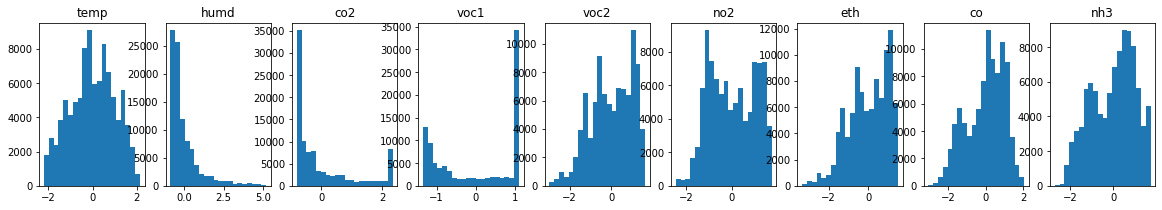

In [ ]:
### Examine the metrics and histograms of the newly standardized data

# Compute metrics of newly standardized data
X_train_std_flattened = np.reshape(X_train_std, 
                                (X_train_std.shape[0] * X_train_std.shape[1], X_train_std.shape[2]))
(means_new, std_devs_new, mins_new, ranges_new) = calc_metrics(X_train_std_flattened)

# Print out the results
print(channel_names)
print("Means:", [float("{:.4f}".format(x)) for x in means_new])
print("Std devs:", [float("{:.4f}".format(x)) for x in std_devs_new])
print("Mins:", [float("{:.4f}".format(x)) for x in mins_new])
print("Ranges:", [float("{:.4f}".format(x)) for x in ranges_new])

# Create subplots
num_hists = len(channel_names)
fig, axs = plt.subplots(1, num_hists, figsize=(20,3))

# Create histogram for each category of data
for i in range(num_hists):
  _ = axs[i].hist(X_train_std_flattened[:,i], bins=20, histtype='bar')
  axs[i].title.set_text(channel_names[i])

## Step 5: Store preprocessed data in CSV files

In [ ]:
### Delete output directory (if it exists) and recreate it
if os.path.exists(OUT_PATH):
  shutil.rmtree(OUT_PATH)
os.makedirs(os.path.join(OUT_PATH, TRAIN_DIR))
os.makedirs(os.path.join(OUT_PATH, TEST_DIR))

In [ ]:
# Add timestamp function
def add_timestamps(X, sample_rate):
  
  # Add timestamps to data
  X_with_timestamp = []
  for idx in range(X.shape[0]):
    sample = []
    for t in range(X.shape[1]):
      timestamp = t * sample_rate
      reading = np.insert(X[idx, i, :], 0, timestamp, axis=0)
      sample.append(reading)
    X_with_timestamp.append(np.array(sample))

  # Convert to Numpy array
  X_with_timestamp = np.array(X_with_timestamp)

  return X_with_timestamp

In [ ]:
### Add timestamps to data

# Add timestamps
X_train_csv = add_timestamps(X_train_std, sample_rate)
X_test_csv = add_timestamps(X_test_std, sample_rate)

# Add timestamp to header
channel_names_csv = ["timestamp"] + channel_names

# Print shapes
print(channel_names_csv)
print("X train CSV:", X_train_csv.shape)
print("X test CSV:", X_test_csv.shape)

['timestamp', 'temp', 'humd', 'co2', 'voc1', 'voc2', 'no2', 'eth', 'co', 'nh3']
X train CSV: (4760, 20, 10)
X test CSV: (1190, 20, 10)


In [ ]:
### Function to write header and data to CSV file to given directory
def write_csv_data(header, data, filepath):
    with open(filepath, 'w') as f:
      csv_writer = csv.writer(f, delimiter=',')
      csv_writer.writerow(header)
      for i in range(data.shape[0]):
        csv_writer.writerow(data[i])

In [ ]:
### Write training and test data to .csv files in separate directories

# Write out training data
dir_path = os.path.join(OUT_PATH, TRAIN_DIR)
for idx in range(len(y_train)):
  label = str(round(y_train[idx]))
  id = uuid.uuid4().hex
  filename = label + "." + id + ".csv"
  filepath = os.path.join(OUT_PATH, TRAIN_DIR, filename)
  write_csv_data(channel_names_csv, X_train_csv[idx], filepath)

# Write out test data
dir_path = os.path.join(OUT_PATH, TEST_DIR)
for idx in range(len(y_test)):
  label = str(round(y_test[idx]))
  id = uuid.uuid4().hex
  filename = label + "." + id + ".csv"
  filepath = os.path.join(OUT_PATH, TEST_DIR, filename)
  write_csv_data(channel_names_csv, X_test_csv[idx], filepath)

In [ ]:
### Zip output directory
%cd {OUT_PATH}
!zip -FS -r -q {OUT_ZIP} *
%cd {HOME_PATH}

/content/out
/content


## Step 6: Test regression model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, DepthwiseConv1D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

In [ ]:
### Build and train model

# Get dimensions
n_channels = X_train_std.shape[2]

# A sequential model is a linear stack of layers
model = Sequential()

# --- Model 1: 1DConv ---
# # Test to mimic Edge Impulse
# model.add(Reshape(target_shape=(20, 9), input_shape=(180,)))

# # First layer: 1D convolution for filtering
# model.add(Conv1D(3,
#                  kernel_size=3,
#                   strides=1,
#                   padding='same',
#                   data_format='channels_last',
#                   activation='relu'))

# model.add(Conv1D(3,
#                  kernel_size=3,
#                   strides=2,
#                   padding='same',
#                   data_format='channels_last',
#                   activation='relu'))

# # Flatten and DNN for classification
# model.add(Flatten())
# model.add(Dropout(0.25))
# model.add(Dense(40,
#                 activation=tf.keras.activations.relu))
# model.add(Dropout(0.25))
# model.add(Dense(1,
#                 activation='linear'))

# --- Model 2: Depthwise 1DConv ---
# # Test to mimic Edge Impulse
# model.add(Reshape(target_shape=(20, 9), input_shape=(180,)))

# # First layer: 1D depthwise convolution for filtering
# model.add(DepthwiseConv1D(3, # kernel size
#                           strides=1,
#                           padding='same',
#                           depth_multiplier=1,
#                           data_format='channels_last',
#                           activation='relu'))

# # Flatten and DNN for classification
# model.add(Flatten())
# model.add(Dropout(0.25))
# model.add(Dense(80,
#                 activation=tf.keras.activations.relu))
# model.add(Dropout(0.25))
# model.add(Dense(1,
#                 activation='linear'))

# # --- Model 3: DNN ---
model.add(Dense(40,
                activation=tf.keras.activations.relu))
model.add(Dropout(0.25))
model.add(Dense(20,
                activation=tf.keras.activations.relu))
model.add(Dropout(0.25))
model.add(Dense(1,
                activation='linear'))

# Configure the model's training settings
opt = Adam(learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999)
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [ ]:
### Train the model

# Flatten dataset (to mimic Edge Impulse)
X_train_reshape = np.reshape(X_train_std, (X_train_std.shape[0], X_train_std.shape[1] * X_train_std.shape[2]))

history = model.fit(X_train_reshape, 
                    y_train, 
                    epochs=500,
                    batch_size=50,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/500
77/77 [==============================] - 1s 5ms/step - loss: 5786.0332 - mse: 5786.0332 - mae: 61.7001 - val_loss: 3006.2839 - val_mse: 3006.2839 - val_mae: 44.6814
Epoch 2/500
77/77 [==============================] - 0s 3ms/step - loss: 2686.6331 - mse: 2686.6331 - mae: 41.5049 - val_loss: 1721.1099 - val_mse: 1721.1099 - val_mae: 32.1103
Epoch 3/500
77/77 [==============================] - 0s 3ms/step - loss: 1732.9603 - mse: 1732.9603 - mae: 32.0396 - val_loss: 1121.6029 - val_mse: 1121.6029 - val_mae: 24.9563
Epoch 4/500
77/77 [==============================] - 0s 3ms/step - loss: 1378.3479 - mse: 1378.3479 - mae: 28.7516 - val_loss: 880.3447 - val_mse: 880.3447 - val_mae: 22.3365
Epoch 5/500
77/77 [==============================] - 0s 3ms/step - loss: 1250.9719 - mse: 1250.9719 - mae: 27.4054 - val_loss: 779.6631 - val_mse: 779.6631 - val_mae: 21.0720
Epoch 6/500
77/77 [==============================] - 0s 3ms/step - loss: 1166.2736 - mse: 1166.2736 - mae: 26.2845 - va

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 40)                7240      
                                                                 
 dropout_27 (Dropout)        (None, 40)                0         
                                                                 
 dense_32 (Dense)            (None, 20)                820       
                                                                 
 dropout_28 (Dropout)        (None, 20)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 21        
                                                                 
Total params: 8,081
Trainable params: 8,081
Non-trainable params: 0
_________________________________________________________________
None


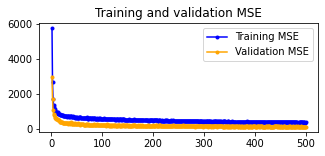

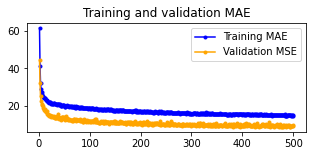

In [ ]:
### Plot training curves

print(model.summary())

# Extract accuracy and loss values (in list form) from the history
mse = history.history['mse']
val_mse = history.history['val_mse']
mae = history.history['mae']
val_mae = history.history['val_mae']

# Create a list of epoch numbers
epochs = range(1, len(mse) + 1)

# Plot training and validation MSE values over time
plt.figure(figsize=(5, 2))
plt.plot(epochs, mse, color='blue', marker='.', label='Training MSE')
plt.plot(epochs, val_mse, color='orange', marker='.', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

# Plot training and validation MAE over time
plt.figure(figsize=(5, 2))
plt.plot(epochs, mae, color='blue', marker='.', label='Training MAE')
plt.plot(epochs, val_mae, color='orange', marker='.', label='Validation MSE')
plt.title('Training and validation MAE')
plt.legend()
plt.show()

In [ ]:
### Test on the test set

# Reshape test set to mimic Edge Impulse
X_test_reshape = np.reshape(X_test_std, (X_test_std.shape[0], X_test_std.shape[1] * X_test_std.shape[2]))

# Make predictions
y_pred = model.predict(X_test_reshape).flatten()

# See how close we were
print("Predicted vs. True")
for i in range(100):
  print(round(y_pred[i], 3), "vs.", round(y_test[i], 3))

38/38 [==============================] - 0s 3ms/step
Predicted vs. True
-12.102 vs. -8.0
78.679 vs. 77.0
56.357 vs. 53.0
-5.875 vs. -11.5
167.985 vs. 168.516
90.313 vs. 92.0
86.026 vs. 94.5
16.101 vs. 15.0
110.75 vs. 104.5
53.65 vs. 53.5
154.404 vs. 159.0
-14.187 vs. -37.5
121.793 vs. 129.0
30.677 vs. 27.549
167.485 vs. 176.0
105.24 vs. 123.515
20.825 vs. 20.0
45.244 vs. 28.5
69.062 vs. 68.0
108.198 vs. 113.0
53.808 vs. 64.024
109.514 vs. 126.0
34.274 vs. 26.0
102.771 vs. 110.0
4.943 vs. 10.0
-20.902 vs. -35.5
1.011 vs. -9.5
32.383 vs. 21.0
-23.419 vs. -30.0
-8.737 vs. -9.5
87.808 vs. 82.5
-6.916 vs. -15.0
9.018 vs. 16.5
41.388 vs. 47.08
79.125 vs. 70.549
143.631 vs. 170.515
9.4 vs. 8.0
99.324 vs. 89.5
54.325 vs. 51.5
88.538 vs. 87.0
107.148 vs. 126.5
74.841 vs. 84.0
66.485 vs. 63.093
-13.923 vs. -22.5
30.279 vs. 40.0
34.218 vs. 41.0
145.824 vs. 168.5
44.104 vs. 32.06
74.361 vs. 74.0
139.088 vs. 149.06
52.869 vs. 62.0
131.323 vs. 131.5
19.435 vs. 12.5
46.708 vs. 46.0
-26.951 vs. -34.5


In [ ]:
# Get MSE of test set
tf.keras.losses.mean_squared_error(y_test, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=145.40926>

In [ ]:
# Are we actually seeing some values less than 0?
np.sum(y_pred < 0)

176

## Step 7: Test on a full sequence

(211, 20, 9)
(211,)
7/7 [==============================] - 0s 7ms/step


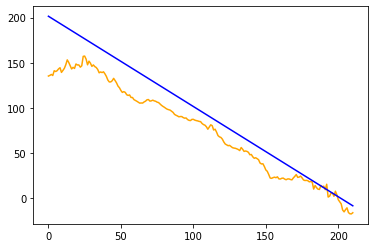

In [ ]:
### Create test batch from a single sequence

test_idx = 15

# Columns to drop
cols_to_delete = [TIMESTAMP_IDX, PRESSURE_IDX, STATE_IDX] 

# Create sliding window gas data (without timestamp and state) to X and "time until burn" to y
win_idx = 0
X_test_seq = []
y_test_seq = []
while win_idx < len(raw_data[test_idx]):

  # Check to make sure we're not exceeding the sequence
  if win_idx + X_WINDOW_LEN > len(raw_data[test_idx]):
    break

  # Generate window, remove unwanted columns
  window = raw_data[test_idx][win_idx:(win_idx + X_WINDOW_LEN), :]
  window = np.delete(window, cols_to_delete, axis=1)

  # Perform standardization and save to our test set
  window = (window - means) / std_devs
  X_test_seq.append(window)
  
  # Copy time until burned (at the end of the window) as our ground truth values
  y_test_seq.append(burn_timestamp - raw_data[test_idx][(win_idx + X_WINDOW_LEN - 1), 0])

  # Mover window up by our stride
  win_idx += X_WINDOW_STRIDE

# Turn into Numpy arrays
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq) / Y_SCALE

# View shapes
print(X_test_seq.shape)
print(y_test_seq.shape)

# Predict time until burnt for test sequence
X_test_reshape = np.reshape(X_test_seq, (X_test_seq.shape[0], X_test_seq.shape[1] * X_test_seq.shape[2]))
y_pred = model.predict(X_test_reshape).flatten()

# Plot actual and predicted times
plt.plot(y_pred, color='orange')
plt.plot(y_test_seq, color='blue')

In [ ]:
### Read new sequence from CSV

test_csv = "/content/freezer.1660169618429.csv"

# Store header, raw data, and number of lines found in each .csv file
header = None

sample_data = []

# Read the .csv file
with open(test_csv) as f:
  csv_reader = csv.reader(f, delimiter=',')

  # Read each line
  valid_line_counter = 0
  for line_count, line in enumerate(csv_reader):

    # Check header
    if line_count == 0:

      # Record first header as our official header for all the data
      if header == None:
        header = line

      # Check to make sure subsequent headers match the original header
      if header == line:
        filenames.append(filename)
      else:
        print("Error: Headers do not match. Skipping", filename)
        break

    # Construct raw data array, make sure number of elements match number of header labels
    else:
      if len(line) == len(header):
        sample_data.append(line)
      else:
        print("Error: Data length does not match header length. Skipping line.")
        continue

# Turn into sequence
raw_seq = np.array(sample_data).astype('float')

# Print shape
print(raw_seq.shape)

(425, 12)


(203, 20, 9)
(203,)
7/7 [==============================] - 0s 3ms/step


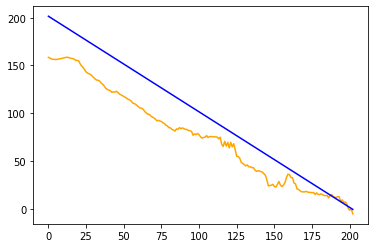

In [ ]:
### Do prediction on new sequence

# Create sliding window gas data (without timestamp and state) to X and "time until burn" to y
win_idx = 0
X_test_seq = []
y_test_seq = []
while win_idx < len(raw_seq):

  # Check to make sure we're not exceeding the sequence
  if win_idx + X_WINDOW_LEN > len(raw_seq):
    break

  # Generate window, remove unwanted columns
  window = raw_seq[win_idx:(win_idx + X_WINDOW_LEN), :]
  window = np.delete(window, cols_to_delete, axis=1)

  # Perform standardization and save to our test set
  window = (window - means) / std_devs
  X_test_seq.append(window)
  
  # Copy time until burned (at the end of the window) as our ground truth values
  y_test_seq.append(burn_timestamp - raw_seq[(win_idx + X_WINDOW_LEN - 1), 0])

  # Mover window up by our stride
  win_idx += X_WINDOW_STRIDE

# Turn into Numpy arrays
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq) / Y_SCALE

# View shapes
print(X_test_seq.shape)
print(y_test_seq.shape)

# Predict time until burnt for test sequence
X_test_reshape = np.reshape(X_test_seq, (X_test_seq.shape[0], X_test_seq.shape[1] * X_test_seq.shape[2]))
y_pred = model.predict(X_test_reshape).flatten()

# Plot actual and predicted times
plt.plot(y_pred, color='orange')
plt.plot(y_test_seq, color='blue')